In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymongo import MongoClient
import copy
import math
from enum import Enum
import requests
import json
import pprint
from os import listdir
import dill
dill.settings['recurse'] = True
from pathos.multiprocessing import ProcessingPool as Pool
import time
from pqdict import PQDict
from matplotlib import colors

userRatingPath = "./data/"

class CollectibleType(Enum):
  All = 1
  Hands = 2
  Feet = 3
  Left = 4
  Right = 5
  LeftHand = 6
  RightHand = 7
  LeftFoot = 8
  RightFoot = 9

client = MongoClient('localhost', 27017)

db = client['beatfork']

versions = db.versions.find()

userRatings = {}
for fileName in listdir(userRatingPath):
  file = open(userRatingPath + fileName)
  userRating = json.load(file)
  id = userRating['_id']['levelId'] + '/' + userRating['_id']['versionId']
  if not id in userRatings:
    userRatings[id] = {
      'overallDifficulty': [],
      'chunkDifficulties': []
    }
  userRatings[id]['overallDifficulty'].append(userRating['overallDifficulty'])
  userRatings[id]['chunkDifficulties'].append(userRating['chunkDifficulties'])
for version in userRatings:
  userRatings[version]['overallDifficulty'] = pd.DataFrame(userRatings[version]['overallDifficulty'])
  userRatings[version]['chunkDifficulties'] = pd.DataFrame(userRatings[version]['chunkDifficulties'])

sns.set(rc={'figure.figsize': (10, 3)})

def calcDistanceXY(posA, posB):
  return ( (posA['x'] - posB['x']) ** 2 + (posA['y'] - posB['y']) ** 2 ) ** (1 / 2)

def calcDistanceZ(posA, posB):
  return abs(posA['z'] - posB['z'])

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


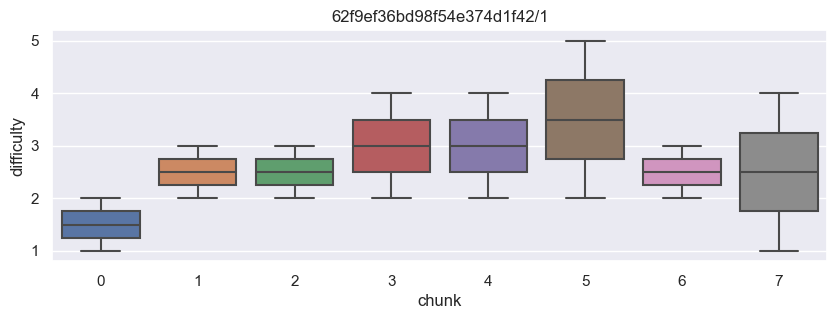

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


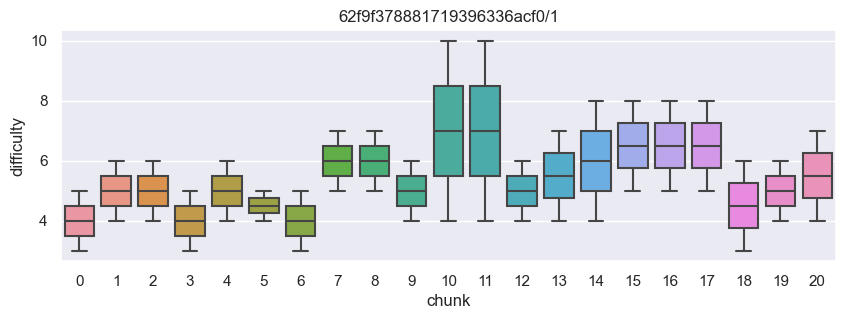

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


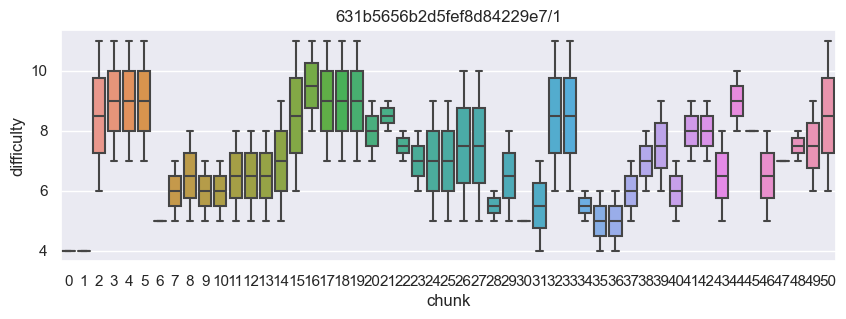

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


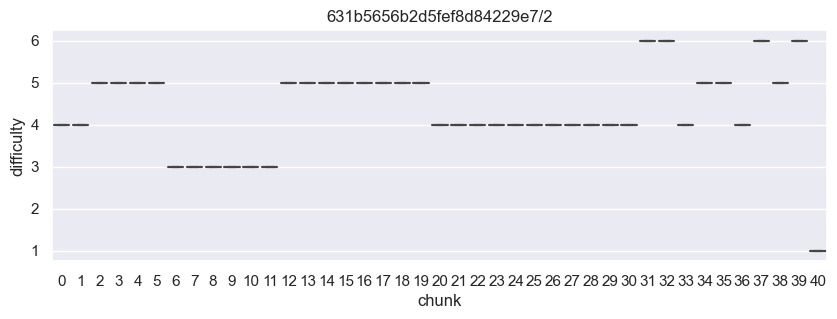

c:\Users\luis\python_environments\beatfork\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


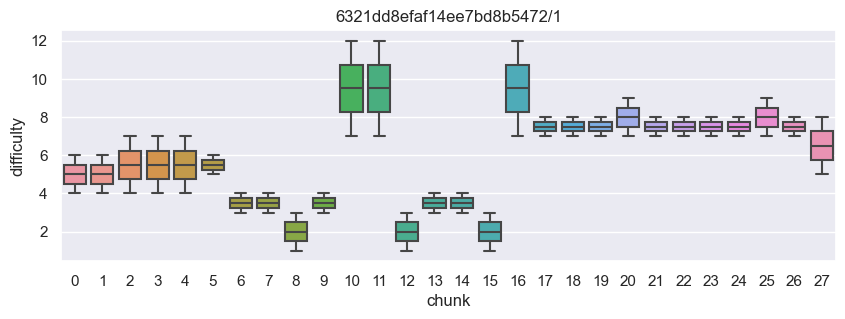

In [115]:
for version in userRatings:
  g = sns.boxplot(
    data=userRatings[version]['chunkDifficulties']
  )
  g.set_title(version)
  g.set_xlabel("chunk")
  g.set_ylabel("difficulty")
  plt.show()

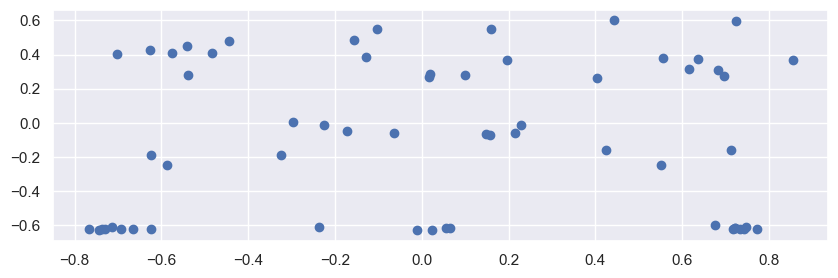

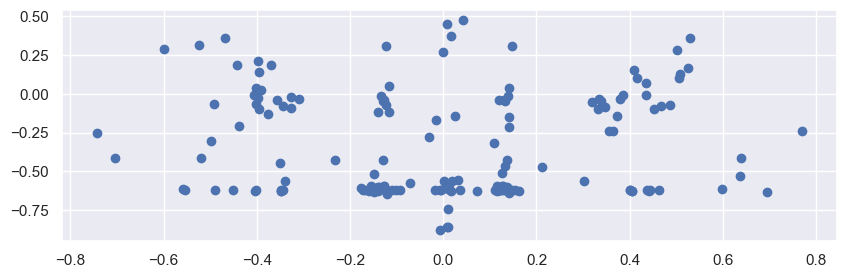

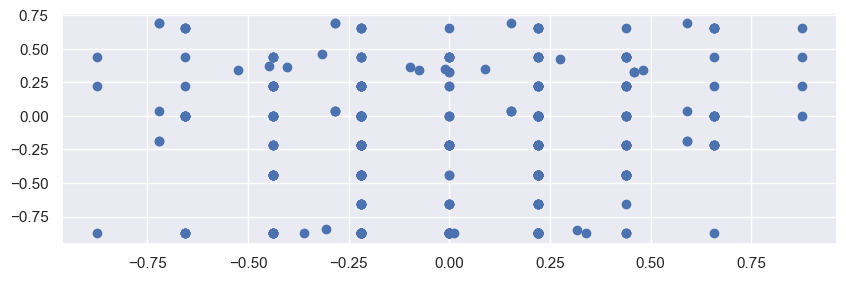

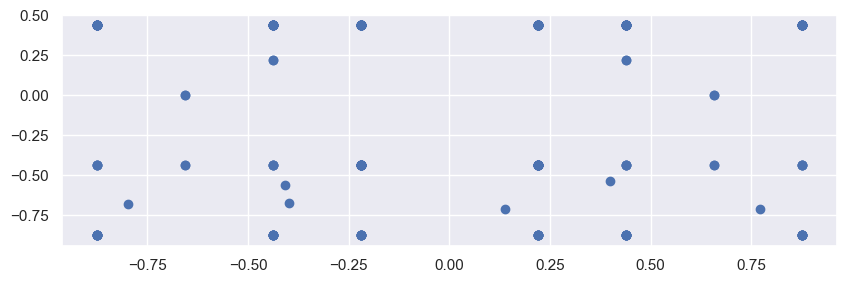

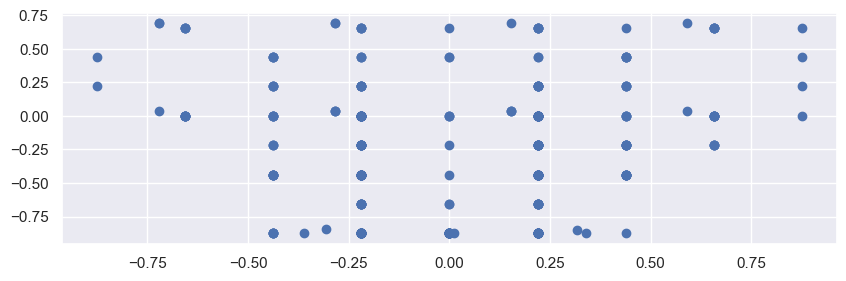

In [116]:
def plotXYOccurence(version):

  x = np.array(list(map(lambda obj:
    obj['position']['x']
  , version['objects'])))
  y = np.array(list(map(lambda obj:
    obj['position']['y']
  , version['objects'])))

  fig, ax = plt.subplots()

  ax.scatter(x, y, vmin=-1, vmax=1)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYOccurence(version)

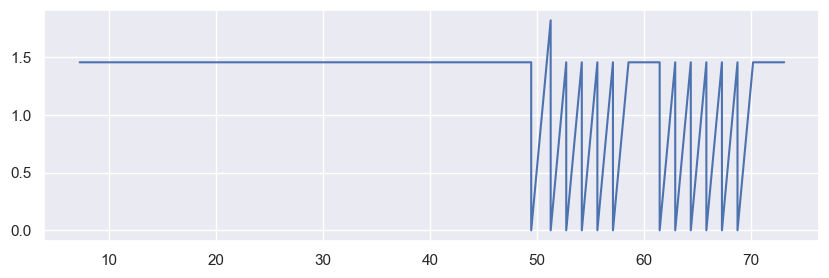

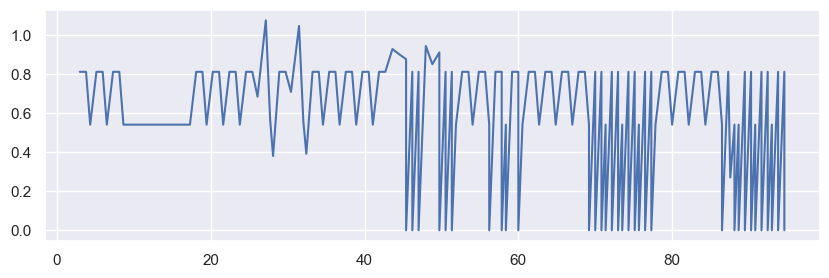

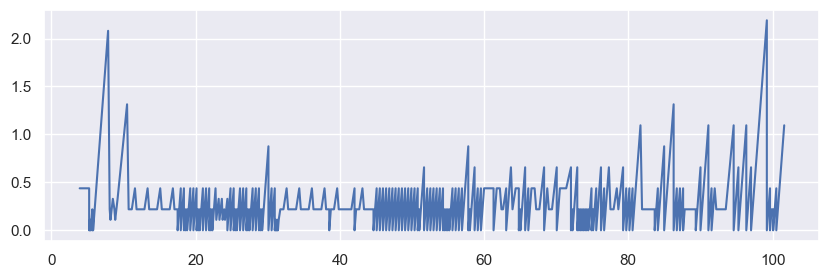

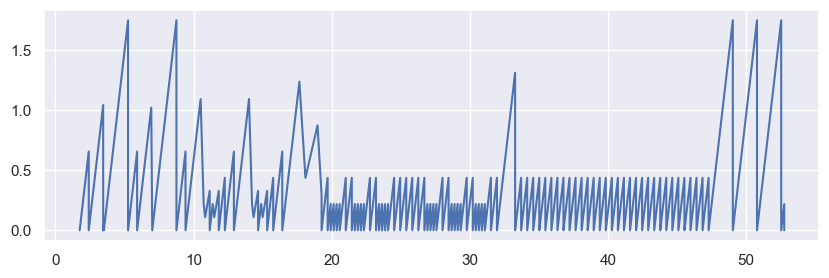

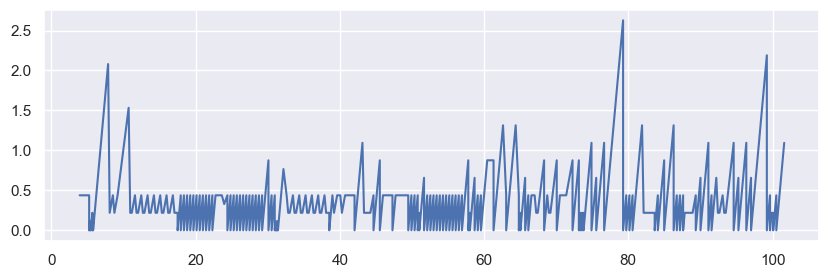

In [117]:
def plotZDistance(version):

  zDistanceBetweenBlocks = []
  lastZ = version['objects'].pop(0)['position']['z']
  for obj in version['objects']:
    zDistanceBetweenBlocks.append(obj['position']['z'] - lastZ)
    lastZ = obj['position']['z']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(zDistanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotZDistance(version)

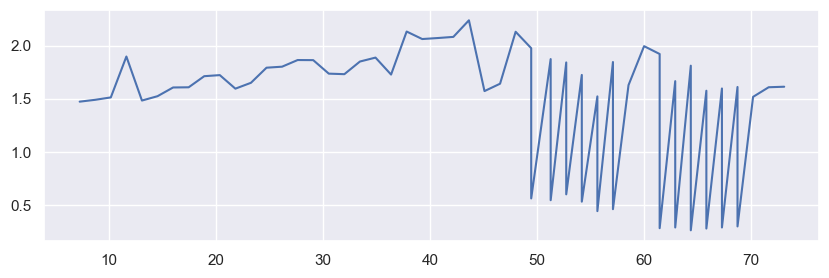

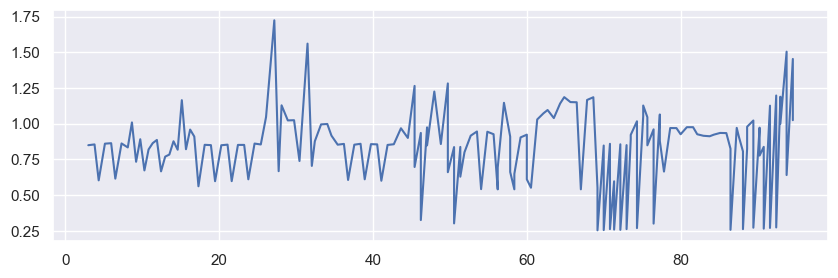

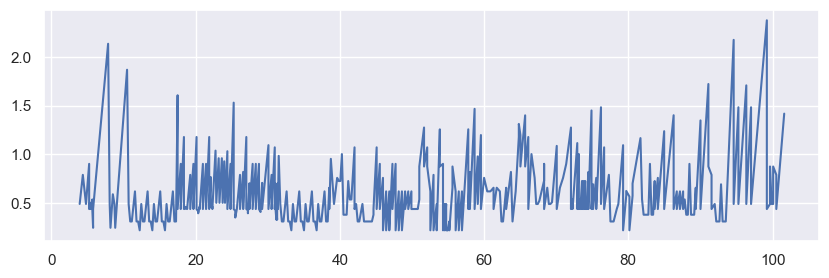

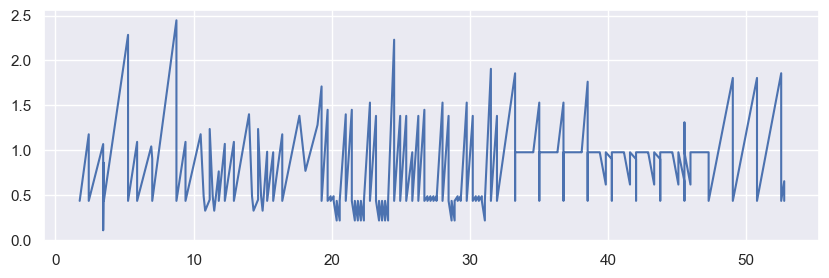

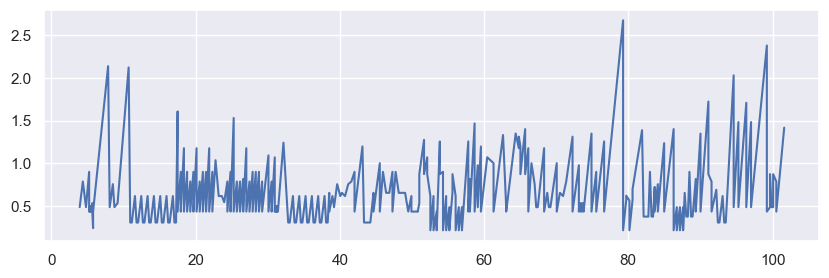

In [118]:
def plotDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 +
      (obj['position']['z'] - lastPosition['z']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotDistance(version)

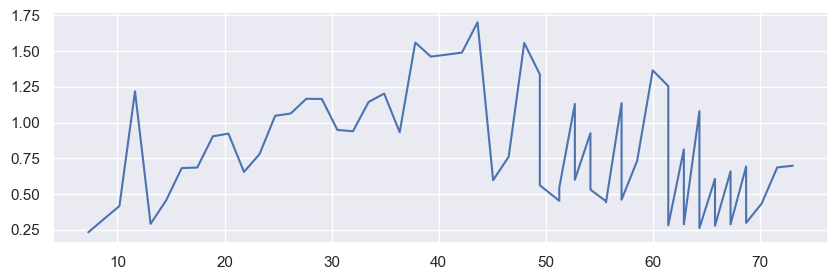

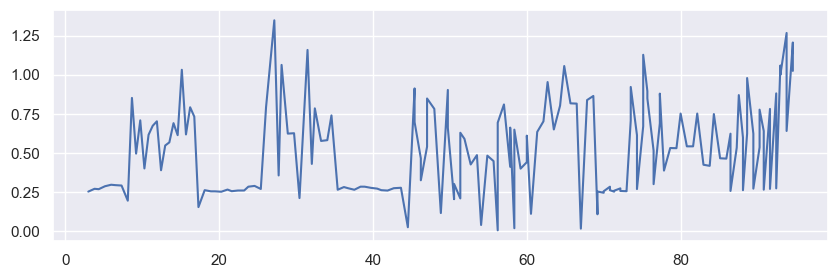

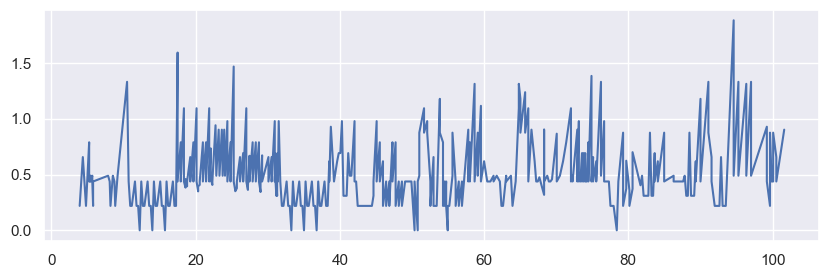

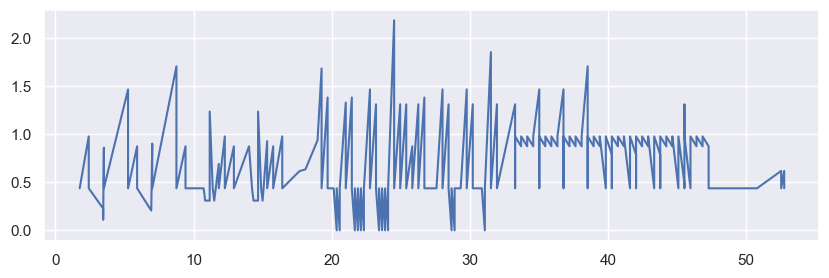

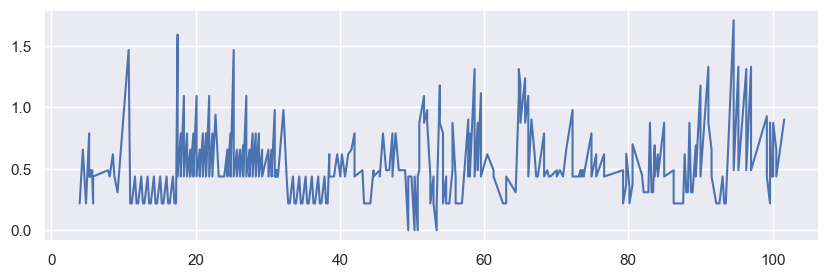

In [119]:
def plotXYDistance(version):

  distanceBetweenBlocks = []
  lastPosition = version['objects'].pop(0)['position']
  for obj in version['objects']:
    distanceBetweenBlocks.append((
      (obj['position']['x'] - lastPosition['x']) ** 2 +
      (obj['position']['y'] - lastPosition['y']) ** 2 ) ** 0.5)
    lastPosition = obj['position']

  x = np.array(list(map(lambda obj:
    obj['position']['z']
  , version['objects'])))
  y = np.array(distanceBetweenBlocks)

  fig, ax = plt.subplots()

  ax.plot(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  plotXYDistance(version)

62f9ef36bd98f54e374d1f42/1


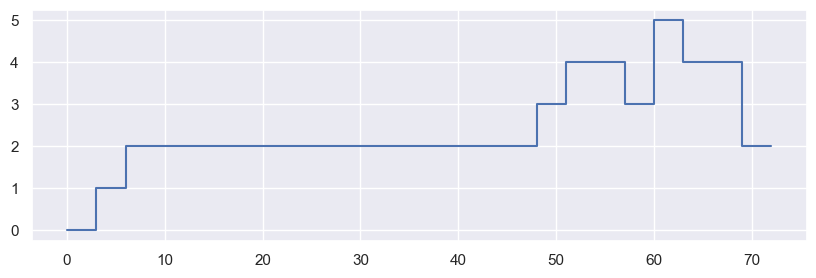

62f9f378881719396336acf0/1


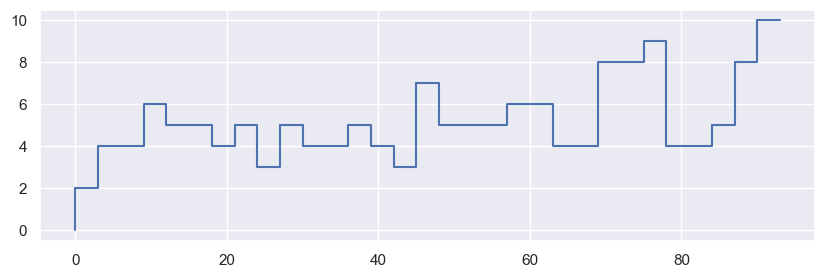

631b5656b2d5fef8d84229e7/1


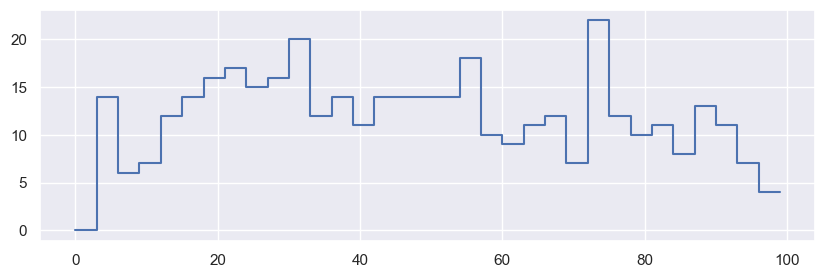

6321dd8efaf14ee7bd8b5472/1


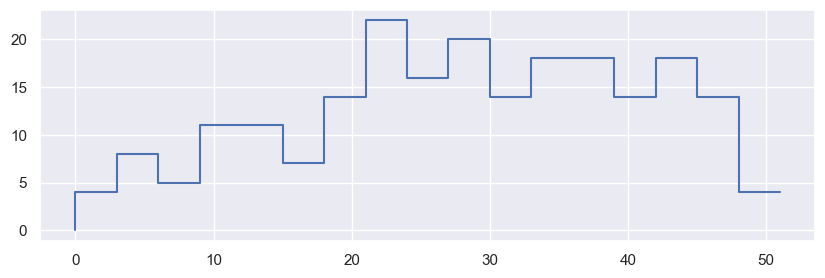

631b5656b2d5fef8d84229e7/2


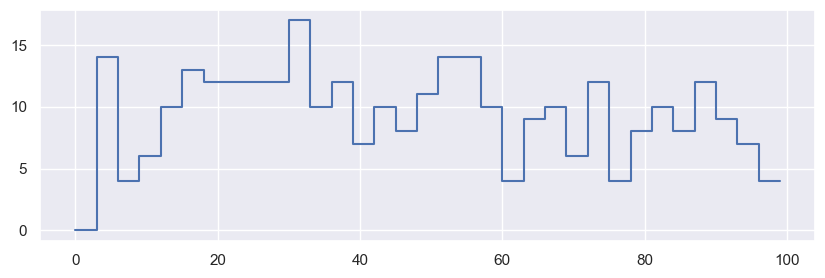

In [120]:
def plotDensity(version):
  secondsPerInterval = 3

  objects = version['objects']
  end = objects[-1]['position']['z']
  density = []
  for i in range(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval):
    obstaclesInInterval = 0
    while len(objects) > 0 and objects[0]['position']['z'] < i:
      obstaclesInInterval += 1
      objects.pop(0)
    density.append(obstaclesInInterval)

  x = np.arange(0, math.ceil(end / secondsPerInterval) * secondsPerInterval, secondsPerInterval)
  y = np.array(density)

  fig, ax = plt.subplots()

  ax.step(x, y)

  plt.show()

for version in copy.deepcopy(versions):
  print(str(version['_id']['levelId']) + '/' + str(version['_id']['versionId']))
  plotDensity(version)

In [128]:
# Sampling (like in signal processing)
# 
# Sampled naive algorithm is still very slow even with low chunk sizes as 8 it takes about 10s to run per level version.
# Converting to JS failed, because JS cannot deal with soo many recursions without further steps.
# Maybe rewrite iteratively. Does that solve the problem though?
# Definitely need more performance for larger chunk sizes.

chunkSize = 8
overlap = 0

def split(myList, chunkSize, overlap):
  for i in range (0, len(myList), chunkSize):
    yield myList[i: i + chunkSize + overlap]

def plotBestOptions(options, chunkSize):

  def removeInf(option):
    for limb in option['cumulatedIntensity'].values():
      if limb == math.inf:
        option['cumulatedIntensity'] = {
          6: 0,
          7: 0,
          8: 0,
          9: 0,
        }
        return option
    return option

  for version in options:
    fig, ax = plt.subplots()
    plt.ylim([0, 12]) # todo

    options[version] = list(map(removeInf, options[version]))

    chunkLabels = list(range(0, len(options[version])))
    leftHandIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.LeftHand.value]
      , options[version])))
    rightHandIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.RightHand.value]
      , options[version])))
    leftFootIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.LeftFoot.value]
      , options[version])))
    rightFootIntensity = np.array(list(map(lambda option:
      option['cumulatedIntensity'][CollectibleType.RightFoot.value]
      , options[version])))
    ax.bar(chunkLabels, leftHandIntensity, label='Left Hand', bottom = np.add(leftFootIntensity, rightFootIntensity), zorder=1)
    ax.bar(chunkLabels, rightHandIntensity, label='Right Hand', bottom = np.add(np.add(leftFootIntensity, rightFootIntensity), leftHandIntensity), zorder=1)
    ax.bar(chunkLabels, leftFootIntensity, label='Left Foot', zorder=1)
    ax.bar(chunkLabels, rightFootIntensity, label='Right Foot', bottom=leftFootIntensity, zorder=1)
    ax.legend()

    ax.boxplot(userRatings[version]['chunkDifficulties'], positions=list(range(0, userRatings[version]['chunkDifficulties'].shape[1])), zorder=2)

    plt.title(version)
    plt.xlabel("chunk")
    plt.ylabel("difficulty")

    plt.show()

In [122]:
def simpleIntensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return float("inf")
  return distance / time

In [123]:
def rightLegAmputeeIntensity(obj, lastPositions):
  if (obj[3] == 9):
    return math.inf
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf
  return distance / time

# plotSampledGetMinIntensity(rightLegAmputeeIntensity)

In [124]:
def intensity(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    return distance / time * (2 + obj[1]) ** 4
  return math.inf

In [125]:
def handsHeightDifficultyFactor(height):
  # return ((height - 0.1) ** 6 + 1)
  return (1.2 * height - 0.4) ** 4 - (0.2 * height) ** 6 + 0.2


def feetHeightDifficultyFactor(height):
  return ((height + 0.875) ** 2.8 + 1)

def intensity2(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time * handsHeightDifficultyFactor(obj[1])
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    # todo: 0 distance cannot mean 0 effort, if in air or balancing on a single leg
    return distance / time * feetHeightDifficultyFactor(obj[1])
  return math.inf

def intensity2(obj, lastPositions):
  distance = ((lastPositions[obj[3]][0] - obj[0]) ** 2 + (lastPositions[obj[3]][1] - obj[1]) ** 2) ** 0.5
  time = abs(lastPositions[obj[3]][2] - obj[2])

  # General edge cases
  if (distance == 0):
    return 0
  if (time == 0):
    return math.inf

  # Hands
  if (obj[3] == 6 or obj[3] == 7):
    return distance / time * handsHeightDifficultyFactor(obj[1])
  # Feet
  elif (obj[3] == 8 or obj[3] == 9):
    return distance / time * ((obj[1] + 0.875) ** 2.8 + 1)
  return math.inf

62f9ef36bd98f54e374d1f42/1 took 0.871s to process.
62f9f378881719396336acf0/1 took 2.298s to process.
631b5656b2d5fef8d84229e7/1 took 4.943s to process.
6321dd8efaf14ee7bd8b5472/1 took 2.811s to process.
631b5656b2d5fef8d84229e7/2 took 4.168s to process.


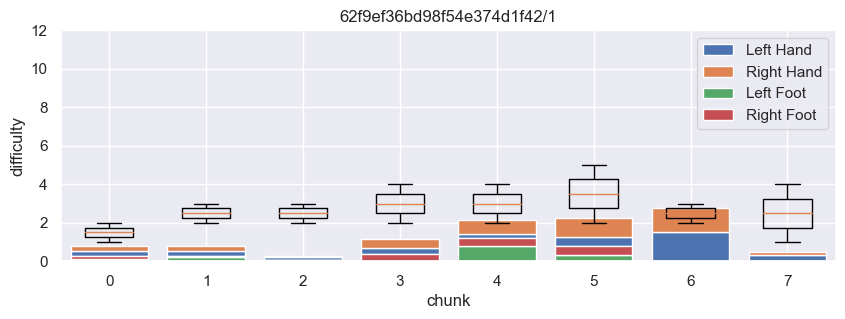

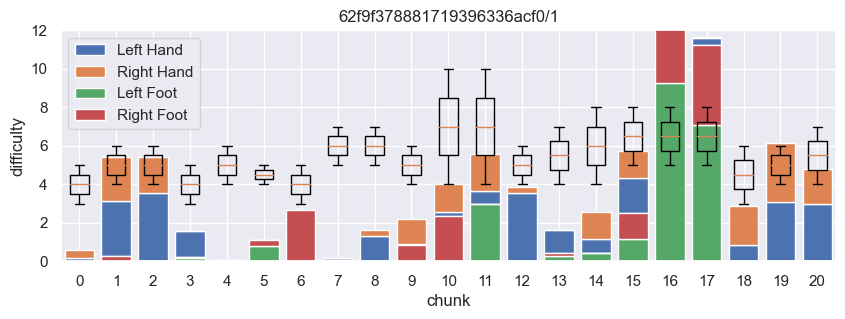

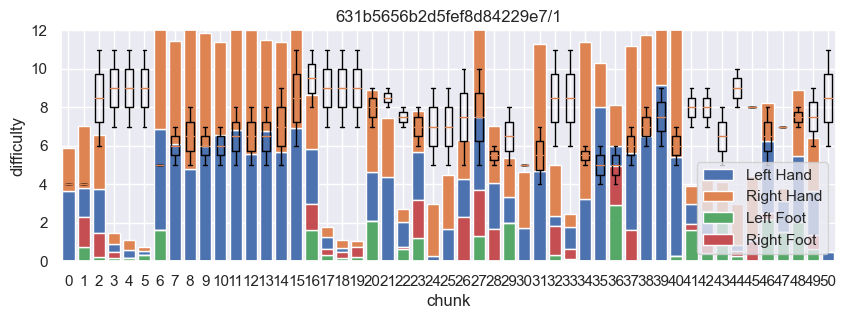

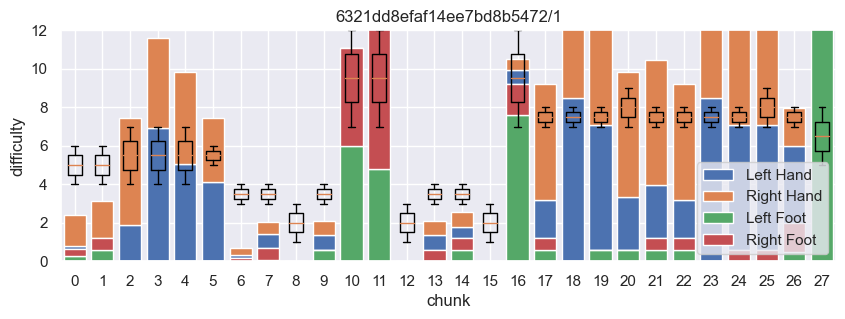

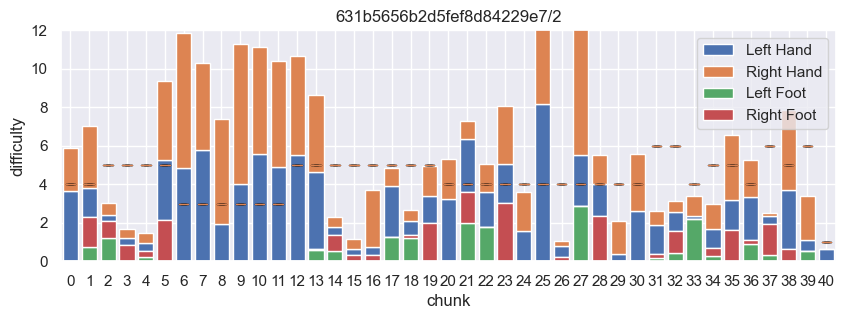

In [129]:
def getMinIntensityDijkstra(objects, cumulatedIntensity, lastPosition, calcIntensity):
  noVertices = 4 ** chunkSize + 2
  distances = [math.inf] * noVertices
  distances[0] = 0
  v = PQDict(zip(range(0, noVertices), distances))
  cumulatedIntensities = [cumulatedIntensity] * noVertices
  lastPositions = [lastPosition] * noVertices
  lastNode = 0

  for currentNode, currentIntensity in v.popitems():
    k = math.ceil(math.log(12 * currentNode + 4, 4) - 1)
    if k == chunkSize or k == len(objects):
      return {
        'cumulatedIntensity': cumulatedIntensities[currentNode],
        'lastPositions': lastPositions[currentNode]
      }
    for i in range(1, 5):
      j = 4 * currentNode + i 
      objType = objects[k][3]
      if  (objType == 1 
           or (objType == 2 and (i == 1 or i == 2))
           or (objType == 3 and (i == 3 or i == 4))
           or (objType == 4 and (i == 1 or i == 3))
           or (objType == 5 and (i == 2 or i == 4))
           or objType == 5 + i):
        obj = copy.deepcopy(objects[k])
        obj[3] = 5 + i
        cumulatedIntensities[j] = copy.deepcopy(cumulatedIntensities[currentNode])
        cumulatedIntensities[j][5 + i] += calcIntensity(obj, lastPositions[currentNode])
        lastPositions[j] = copy.deepcopy(lastPositions[currentNode])
        lastPositions[j][5 + i] = [objects[k][0], objects[k][1], objects[k][2]]
        v[j] = (
          (cumulatedIntensities[j][6] ** 2) +
          (cumulatedIntensities[j][7] ** 2) +
          (cumulatedIntensities[j][8] ** 2) +
          (cumulatedIntensities[j][9] ** 2)
        )
      elif objType == 0:
        cumulatedIntensities[j] = copy.deepcopy(cumulatedIntensities[currentNode])
        lastPositions[j] = copy.deepcopy(lastPositions[currentNode])
        v[j] = currentIntensity

def determineBestOptionDijkstra(version, calcIntensity):
  tStart = time.time()
  # chunks = list(split(version['objects'], chunkSize, overlap))
  chunks = list(split(version['objects'], 8, 0))
  startPositions = {
    6: [-0.3, 0, 0],
    7: [0.3, 0, 0],
    8: [-0.2, -1, 0],
    9: [0.2, -1, 0]
  }
  id = str(version['_id']['levelId']) + '/' + str(version['_id']['versionId'])
  bestOption = []
  for chunk in chunks:
    bestOption.append(getMinIntensityDijkstra(
      list(map(lambda obj:
        [
          obj['position']['x'],
          obj['position']['y'],
          obj['position']['z'],
          obj['collectibleType'] if obj['type'] == "Collectible" else 0
        ]
      , chunk)),
      {
        6: 0,
        7: 0,
        8: 0,
        9: 0,
      },
      startPositions,
      calcIntensity
    ))
    startPositions = bestOption[-1]['lastPositions']
  return {
    'id': id,
    'option': bestOption,
    'executionTime': time.time() - tStart
  }

def plotSampledGetMinIntensityDijkstra(calcIntensity):
  bestOptions = {}
  # for version in list(copy.deepcopy(versions)):
  #   result = determineBestOptionDijkstra(version, calcIntensity)
  #   bestOptions[result['id']] = result['option']

  noWorkers = len(list(versions.clone()))
  p = Pool(noWorkers)
  results = p.map(determineBestOptionDijkstra, list(copy.deepcopy(versions)), [calcIntensity] * noWorkers)
  for result in results:
    print(f'{result["id"]} took {result["executionTime"]:.3f}s to process.')
    bestOptions[result['id']] = result['option']
  plotBestOptions(bestOptions, chunkSize)

plotSampledGetMinIntensityDijkstra(intensity)

62f9ef36bd98f54e374d1f42/1 took 0.883s to process.
62f9f378881719396336acf0/1 took 2.323s to process.
631b5656b2d5fef8d84229e7/1 took 4.908s to process.
6321dd8efaf14ee7bd8b5472/1 took 2.875s to process.
631b5656b2d5fef8d84229e7/2 took 3.946s to process.


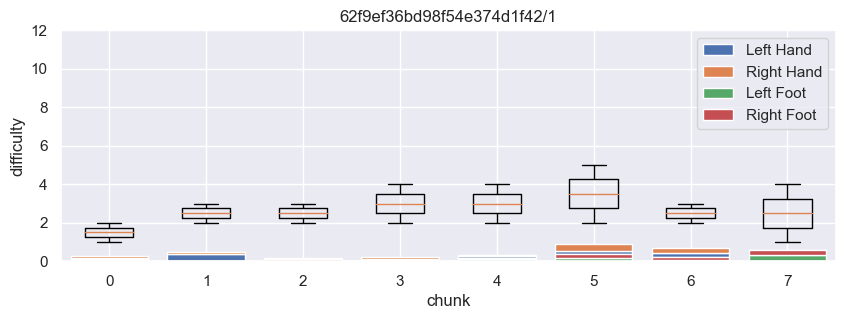

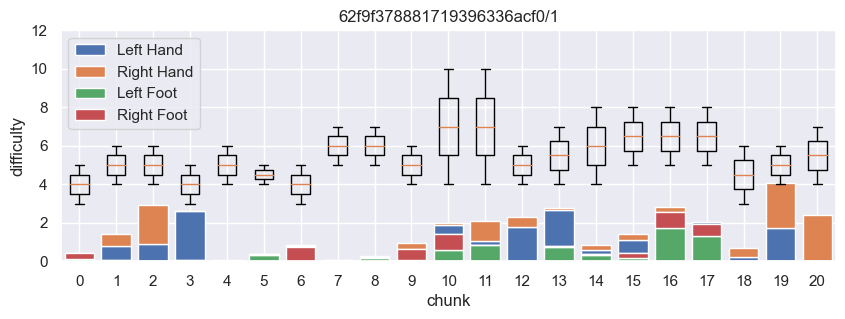

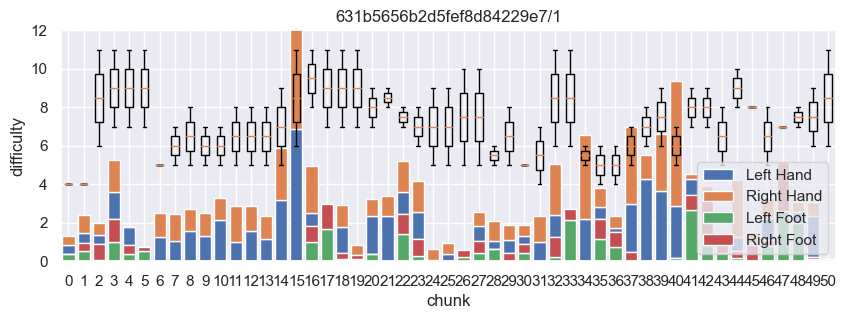

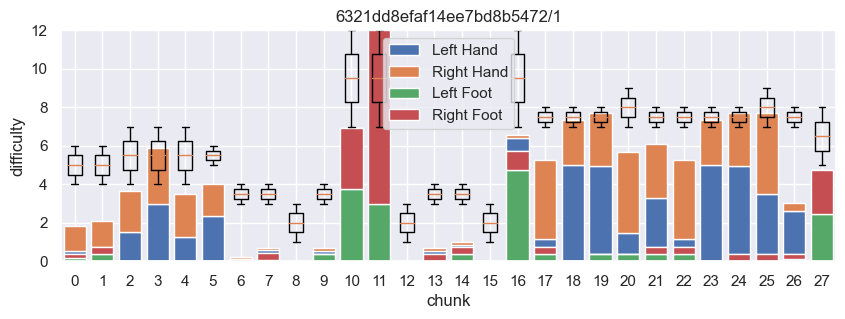

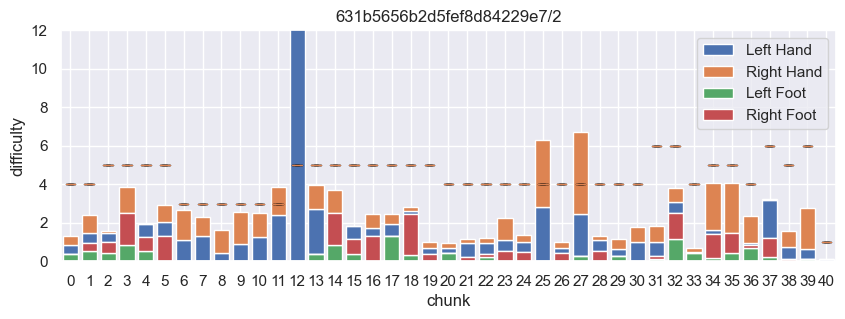

In [130]:
plotSampledGetMinIntensityDijkstra(intensity2)